In [1]:
!pip install datasets

In [2]:
import tensorflow as tf


In [31]:
from datasets import load_dataset

ds = load_dataset("navhci/cat-breed-class")

import numpy as np

def has_three_channels(example): #filter out the dataset: remove grayscale images because resnet handles rgb colors only and images that have 3 dimensions
    image = np.array(example["image"])
    return image.ndim == 3 and image.shape[-1] == 3

filtered_ds = ds.filter(has_three_channels)


Resolving data files:   0%|          | 0/1227 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/600 [00:00<?, ?it/s]

Filter:   0%|          | 0/1227 [00:00<?, ? examples/s]

Filter:   0%|          | 0/600 [00:00<?, ? examples/s]

In [32]:
print(filtered_ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1218
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 596
    })
})


In [53]:
class_names = filtered_ds['train'].unique('label')

print(class_names) #0 - Abyssian, 1-munchkin 2-Persian 3- Toyger
#26.4% Persian
#25.7% Abyssian
#24.2% Toyger
#23.7% munchkin


[0, 1, 2, 3]


In [33]:
import numpy as np #wala rani, this is just to check the shape of the images
for example in filtered_ds["train"].take(20):
    image = example["image"]
    if isinstance(image, tf.Tensor):
        print(image.shape)
    elif isinstance(image, np.ndarray):
        print(image.shape)
    else:
        image = np.array(image)
        print(image.shape)


(1300, 1300, 3)
(768, 1152, 3)
(316, 400, 3)
(864, 780, 3)
(1414, 2121, 3)
(800, 533, 3)
(180, 250, 3)
(499, 333, 3)
(1355, 900, 3)
(1106, 1106, 3)
(1431, 1500, 3)
(781, 706, 3)
(350, 500, 3)
(435, 750, 3)
(555, 1024, 3)
(703, 825, 3)
(267, 400, 3)
(1427, 1000, 3)
(615, 800, 3)
(1155, 1600, 3)


In [34]:
# Convert splits to TensorFlow dataset (instead of DatasetDict) so that ma preprocess sha the same way sa ge show ni sir
valid_test_split = filtered_ds["validation"].train_test_split(test_size=0.2)

train_set_raw = filtered_ds["train"].to_tf_dataset(columns=["image"], label_cols=["label"], batch_size=None)
valid_set_raw = filtered_ds["validation"].to_tf_dataset(columns=["image"], label_cols=["label"], batch_size=None)
test_set_raw = valid_test_split["test"].to_tf_dataset(columns=["image"], label_cols=["label"], batch_size=None)

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [43]:
print(test_set_raw)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [38]:
def preprocess(image,label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = tf.keras.applications.resnet.preprocess_input(resized_image)
    return final_image, label


In [39]:
batch_size = 16
train_set = train_set_raw.shuffle(500)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [10]:
print(train_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [40]:

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='avg',  # Global Average Pooling
    name="resnet50"
)

# Add a classification head
output = tf.keras.layers.Dense(4, activation="softmax")(base_model.output)

# Create final model
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [41]:
for layer in base_model.layers:
  layer.trainable = False

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2,
                                    momentum=0.9,
                                    decay=0.01)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


history = model.fit(train_set,
                    epochs=5,
                    validation_data=valid_set)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 408s 5s/step - accuracy: 0.6513 - loss: 43.0398 - val_accuracy: 0.8876 - val_loss: 15.2763
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.8870 - loss: 17.9369 - val_accuracy: 0.9178 - val_loss: 11.4382
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - accuracy: 0.8822 - loss: 13.6120 - val_accuracy: 0.9128 - val_loss: 14.2459
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.8871 - loss: 19.0409 - val_accuracy: 0.8977 - val_loss: 20.8266
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - accuracy: 0.9415 - loss: 5.4954 - val_accuracy: 0.9211 - val_loss: 15.3547


In [44]:
predictions = model.predict(test_set, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step


In [45]:
print(predictions[:10])

[[0.99999994 0.         0.         0.        ]
 [0.         0.         0.99999994 0.        ]
 [0.99999994 0.         0.         0.        ]
 [0.         0.         0.99999994 0.        ]
 [0.         0.         0.99999994 0.        ]
 [0.         0.         0.99999994 0.        ]
 [0.         0.         0.99999994 0.        ]
 [0.99999994 0.         0.         0.        ]
 [0.         0.         0.99999994 0.        ]
 [0.         0.99999994 0.         0.        ]]


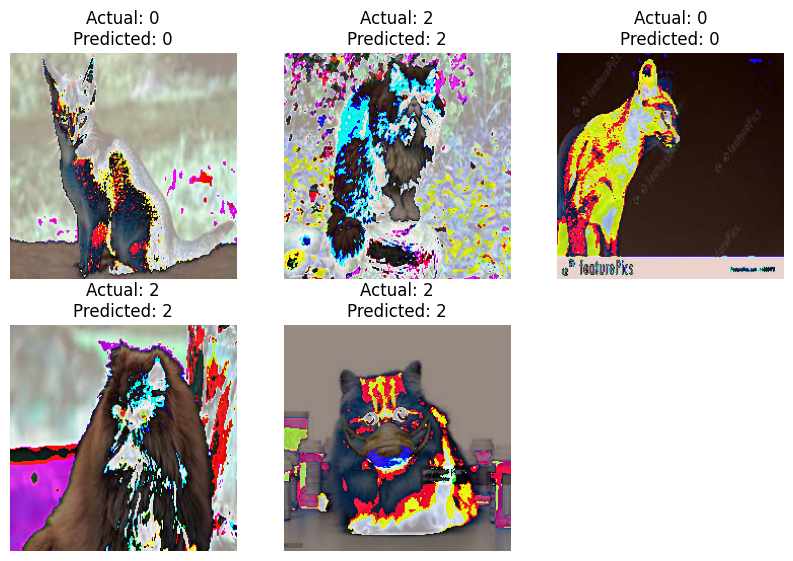

In [60]:
import matplotlib.pyplot as plt
import numpy as np

#0 - Abyssian, 1-munchkin 2-Persian 3- Toyger


#26.4% Persian
#25.7% Abyssian
#24.2% Toyger
#23.7% munchkin


for images, labels in test_set.take(1):  # Take one batch
    predicted_labels = np.argmax(predictions, axis=1)


    num_images = len(images)
    max_images_to_display = 5
    num_images_to_display = min(num_images, max_images_to_display)

    plt.figure(figsize=(10, 10))
    for i in range(num_images_to_display):
        ax = plt.subplot(3, 3, i + 1)  # 3x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()